Boucle globale de lecture de vidéo


state= 0
    img_calibration
    obstacle detection
    start and goal
    global_nav
    
state = 1
    img_calibration
    detect Thymio
    astolfi ou local nav
    
    

In [1]:
#lancer la communication asynchrone avec thymio
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

#vérifier d'avoir installer pyserial

Node eb16048f-962c-44b2-9651-cc3b67bca83b

# Initialisation

In [2]:
#check each import if it's really necessary
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

#import from global control
#import from glocal + control
import pyvisgraph as vg
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Polygon, Point, LineString
import time

In [3]:
import Vision as vis
import Global as glob
import control as ctrl
import local_nav as local

frame 0
frame 1
frame 2
frame 3
frame 4


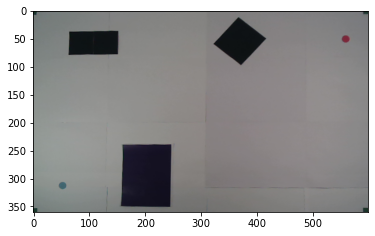

In [4]:
#pour le test utilise une image mais en vrai relier à la caméra et temps réel

cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()


#img_final= cv2.flip(img_final, 0)
img_final2 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
corner_coord=vis.find_corners(img_final2)
img=vis.img_calibration(img_final2,corner_coord)
#cv2.imwrite('warpped.png', zzz)
plt.figure()
plt.imshow(img)
plt.show()



In [5]:
#obstacle detection
polygons=vis.obstacle_detection(img)
#Start and goal detection
start=vis.detectCircle(img,'start')
goal=vis.detectCircle(img,'goal')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 571.59it/s]


Visibility graph points:  [[Point(281.00, 202.19), Point(124.62, 205.78), Point(121.36, 385.00), Point(281.00, 385.00)], [Point(189.73, 3.42), Point(32.49, 1.63), Point(24.38, 112.58), Point(184.32, 114.38)], [Point(361.56, -34.95), Point(270.26, 64.64), Point(375.95, 144.96), Point(469.34, 45.35)]] 

Shortest path distance: 592.6915166951123 

0    POLYGON ((281.000 202.186, 124.616 205.781, 12...
1    POLYGON ((189.729 3.415, 32.495 1.628, 24.376 ...
2    POLYGON ((361.562 -34.954, 270.265 64.642, 375...
0                               POINT (53.500 312.500)
1                              POINT (124.616 205.781)
2                              POINT (375.949 144.962)
3                               POINT (559.237 51.237)
dtype: geometry 

path  0     POINT (53.500 312.500)
1    POINT (124.616 205.781)
2    POINT (375.949 144.962)
3     POINT (559.237 51.237)
dtype: geometry


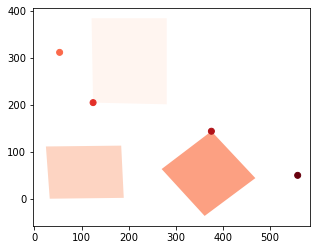

In [6]:
#plot the visibility graph

#a voir si on le met dedans
margin = 35
path=glob.global_pathplanning(start,goal,polygons,margin)


# Control and navigation loop

In [7]:
#cap=cv2.VideoCapture(0)

frame 0
frame 1
frame 2
frame 3
frame 4


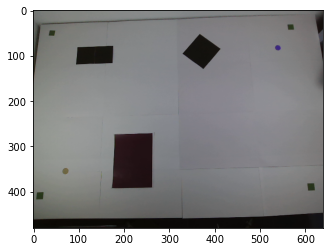

In [7]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)

for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

In [8]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#img= cv2.flip(img, 0)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

TypeError: img_calibration() missing 1 required positional argument: 'corner_coord'

In [9]:
def initialisation(pic):
    #obstacle detection
    polygons=vis.obstacle_detection(pic)
    #Start and goal detection
    start=vis.detectCircle(pic,'start')
    goal=vis.detectCircle(pic,'goal')
    init=[start,goal,polygons]
    return init



In [10]:
#convertir frame to real => mm/s vitesse et position

#coefficients for the Astolfi controller (distances in millimeter)
r=22
l=48 
kp=25  #2 #>0
ka=50  #must be > kp
kb=-0.0001 #<0

#coeff_commtoreal=0,38

#astolfi return to iterate on the next goal from the path list

def astolfi(actual_pos, goal_pos, actual_angle, node):
    #déplacer les variables à l'extérieur dans control
    switch_next=0
    thresh_close2=10
    thresh_close1=75
    comm_sat_min=100
    comm_sat_max=250
    
    delta=np.subtract(goal_pos,actual_pos)
    pho=np.sqrt(np.sum(np.square(delta)))
    alpha=-np.radians(actual_angle) + np.arctan2(-delta[1],delta[0])
    beta=-actual_angle-alpha
    v=kp*pho
    if(pho<thresh_close1):
        v=comm_sat_min*r
    if(pho<thresh_close2):
        v=0
        switch_next=1      
    omega=ka*alpha+kb*beta
    #omega=0
    right_speed=(l*omega+v)/r
    left_speed=(v-l*omega)/r
    left_speed=int(left_speed)
    right_speed=int(right_speed)
    ctrl.set_motors(left_speed, right_speed, node)
    return switch_next

In [11]:
def printGlobalPath(path, img):
    lineThickness = 3
    for i in range(0,len(path)-1):
        cv2.line(final, (round(path[i][0]), round(path[i][1])),(round(path[i+1][0]), round(path[i+1][1])), (0,255,0), lineThickness)

In [ ]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

#cap.release()
#plt.figure()
#plt.imshow(frame)
#plt.show()

time.sleep(1)
state=0
margin = 40
switch_next=0
path_iter=1

while (cap.isOpened()):
    _, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #final=vis.img_calibration(img, corner_coord)
    #img= cv2.flip(img, 0)
    if(state==0):
        corner_coord=vis.find_corners(img)
        final=vis.img_calibration(img, corner_coord)
        init=initialisation(final)
        path=glob.global_pathplanning(init[0],init[1],init[2],margin)
        state=1
    if state==1:
        time.sleep(6)
        state=2
    if state==2:
        final=vis.img_calibration(img, corner_coord)
        pos_thym=vis.detectThymio(final)[0]
        angle_thym=vis.directionThymio(final)
        #print(pos_thym)
        #print(angle_thym)
        #y = [50,50]
        #ctrl.set_motors(y[0],y[1],node)
        switch_next=astolfi(pos_thym,path[path_iter],angle_thym,node)
        if(switch_next==1):
            path_iter=path_iter+1
            print("path iter ",path_iter)
            if(path_iter==len(path)):
                ctrl.stopmotors(node)
                print("finish")
                state=3
            
        #print("sorti")
        #delta=np.subtract(path[1],thym[0])
        #pho=np.sqrt(np.sum(np.square(delta)))
        #print(pho)
        #ctrl.stopmotors(node)
        #if(pho < )
            #state=2
    if state==4:
        break
    vis.printGlobalPath(path, final)
    cv2.imshow("results", final)
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

frame 0
frame 1
frame 2
frame 3
frame 4


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]



Visibility graph points:  [[Point(123.44, 197.55), Point(116.55, 387.08), Point(286.27, 390.89), Point(289.72, 199.47)], [Point(363.49, -41.67), Point(263.19, 65.32), Point(379.07, 151.66), Point(477.13, 44.69)]] 

Shortest path distance: 599.5491802571618 

0    POLYGON ((123.444 197.554, 116.553 387.079, 28...
1    POLYGON ((363.487 -41.671, 263.187 65.316, 379...
0                               POINT (54.500 311.500)
1                              POINT (123.444 197.554)
2                              POINT (379.072 151.662)
3                               POINT (560.237 52.237)
dtype: geometry 

path  0     POINT (54.500 311.500)
1    POINT (123.444 197.554)
2    POINT (379.072 151.662)
3     POINT (560.237 52.237)
dtype: geometry
failure in identifying corners
path iter  2
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying corners
failure in identifying c

In [16]:
ctrl.stopmotors(node)

In [19]:
print(init)

[[112.5, 369.5], [0, 0], [[(253, 285), (298, 291), (283, 374), (238, 368)], [(180, 161), (186, 213), (124, 224), (120, 171)], [(382, 139), (439, 144), (436, 199), (377, 193)]]]


In [7]:
# Navigation initialisation
checkp=1           # goal checkpoint
actual_angle=0     # angle to xy axis
y = [0,0]          # powers given to motor wheels

# FSM initialisation
state = 0          # States FSM 0=global nav, 1=local nav
obst = [0,0,0]     # measurements from left, middle, right prox sensors
obstThrL = 2500      # low obstacle threshold to switch state 1->0
obstThrL2 = 3000
obstThrH = 4000      # high obstacle threshold to switch state 0->1  

while True:
    
    # get the proximity sensors values and obstacle update
    prox_horizontal = ctrl.read_prox_sensors(node,client)
    obst = [prox_horizontal[0], prox_horizontal[2], prox_horizontal[4]]
    
    # update the state and speed motors values
    state = local.update_state(state,obstThrL,obstThrH, obst)
    y = ctrl.read_motors_speed(node,client)
    
    print("state", state)

    if state == 0:
        
        """
        # With positon estimation when vision and/or kalman ready
        
        actual,angle = getting_vis()
        pred_pos,pred_angle = kalman(actual, angle)
        
        actual_pos=pred_pos
        actual_angle=pred_angle
        
        if actual_pos == checkpoints[checkp]: # other option: if (actual_pos - checkpoints[checkp]) < error
            checkp=checkp+1
        goal_pos=checkpoints[checkp]
        
        y = ctrl.astolfi2(actual_pos, goal_pos, actual_angle, node)
        
        """
        y = [50,50]
        ctrl.set_motors(y[0],y[1],node)

    elif state == 1:
        print("obstacles values", obst)
        y = local.local_nav(prox_horizontal,y)
        print("y ",y)
        ctrl.set_motors(y[0],y[1],node)

ctrl.stopmotors(node)

NameError: name 'node' is not defined

In [6]:
ctrl.stopmotors(node)